In [15]:
import requests
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import mlflow
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
splits = ["train", "test"]

dataframes = []

for split in splits:
    
    url = f"https://datasets-server.huggingface.co/rows?dataset=SetFit%2Famazon_polarity&config=default&split={split}&limit=10000"

    response = requests.get(url)
    data = response.json()
    
    rows = data["rows"]
    
    df_split = pd.DataFrame([row["row"] for row in rows])

    df_split["split"] = split
    
    dataframes.append(df_split)

df = pd.concat(dataframes, ignore_index=True)

print(df.head())
print(f"Tamaño total del dataset: {len(df)}")


   label                                              title  \
0      1                     Stuning even for the non-gamer   
1      1              The best soundtrack ever to anything.   
2      1                                           Amazing!   
3      1                               Excellent Soundtrack   
4      1  Remember, Pull Your Jaw Off The Floor After He...   

                                                text label_text  split  
0  This sound track was beautiful! It paints the ...   positive  train  
1  I'm reading a lot of reviews saying that this ...   positive  train  
2  This soundtrack is my favorite music of all ti...   positive  train  
3  I truly like this soundtrack and I enjoy video...   positive  train  
4  If you've played the game, you know how divine...   positive  train  
Tamaño total del dataset: 200


In [4]:

# Función para limpiar el texto. Convierte minsuculas, elimina caracteres esespeciales, quita espacios extras
def limpiar_texto(texto):
    texto = texto.lower() 
    texto = re.sub(r'\W', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

df["text"] = df["text"].apply(limpiar_texto)

print(df.head())

   label                                              title  \
0      1                     Stuning even for the non-gamer   
1      1              The best soundtrack ever to anything.   
2      1                                           Amazing!   
3      1                               Excellent Soundtrack   
4      1  Remember, Pull Your Jaw Off The Floor After He...   

                                                text label_text  split  
0  this sound track was beautiful it paints the s...   positive  train  
1  i m reading a lot of reviews saying that this ...   positive  train  
2  this soundtrack is my favorite music of all ti...   positive  train  
3  i truly like this soundtrack and i enjoy video...   positive  train  
4  if you ve played the game you know how divine ...   positive  train  


In [5]:
# Separar features (text) y labels (positivos y negativos)
X = df["text"]
y = df["label"] 

# Dividir en conjunto de entrenamiento (90%) y prueba (10%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(f"Tamaño del entrenamiento: {len(X_train)}")
print(f"Tamaño de la prueba: {len(X_test)}")

Tamaño del entrenamiento: 180
Tamaño de la prueba: 20


In [6]:
# Convertir texto a vectores numéricos usando TF-IDF (CONVERTR TEXTO EN REPRESENTACIONES NUMERICAS)
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Vectorización completa.")

Vectorización completa.


## Regresion logistica

In [18]:
# Entrenar modelo - Regresion logistica
modelo = LogisticRegression()
modelo.fit(X_train_tfidf, y_train)

# Evaluar modelo
y_pred = modelo.predict(X_test_tfidf)

# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.95
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.92      1.00      0.96        12

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20



In [8]:

X_train_tfidf_dense = X_train_tfidf.toarray()

# Evaluación con validación cruzada (evalua el modelo y asegura que no está sobre ajustado)
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []

for t in train_sizes:
    subset_size = int(t * len(X_train))

    if subset_size > 1:
        cv_splits = min(5, subset_size)  

        print(f"Evaluando con {subset_size} muestras y {cv_splits} splits...")
        try:
            score = cross_val_score(modelo, X_train_tfidf_dense[:subset_size], y_train[:subset_size], cv=cv_splits).mean()
            train_scores.append(score)
        except Exception as e:
            print(f"Error en la validación cruzada: {e}")
            train_scores.append(np.nan)
    else:
        train_scores.append(np.nan)


Evaluando con 18 muestras y 5 splits...
Evaluando con 36 muestras y 5 splits...
Evaluando con 54 muestras y 5 splits...
Evaluando con 72 muestras y 5 splits...
Evaluando con 90 muestras y 5 splits...
Evaluando con 108 muestras y 5 splits...
Evaluando con 126 muestras y 5 splits...
Evaluando con 144 muestras y 5 splits...
Evaluando con 162 muestras y 5 splits...
Evaluando con 180 muestras y 5 splits...


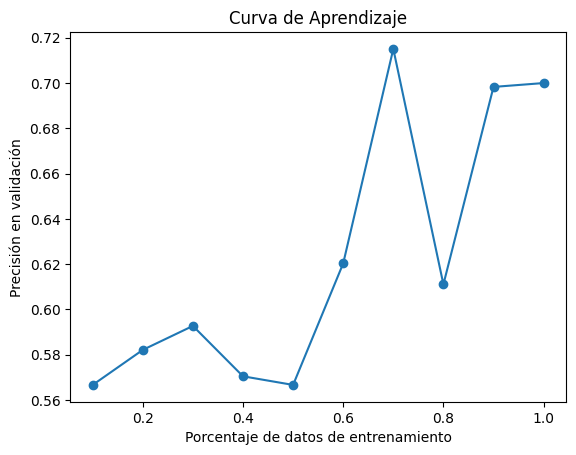

In [9]:
# Graficar curva de aprendizaje
plt.plot(train_sizes, train_scores, marker='o')
plt.xlabel("Porcentaje de datos de entrenamiento")
plt.ylabel("Precisión en validación")
plt.title("Curva de Aprendizaje")
plt.show()

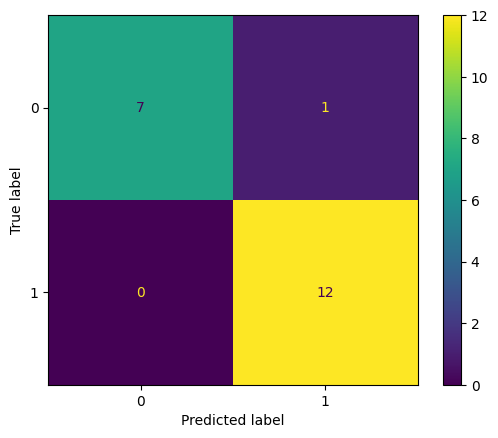

In [10]:
#Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

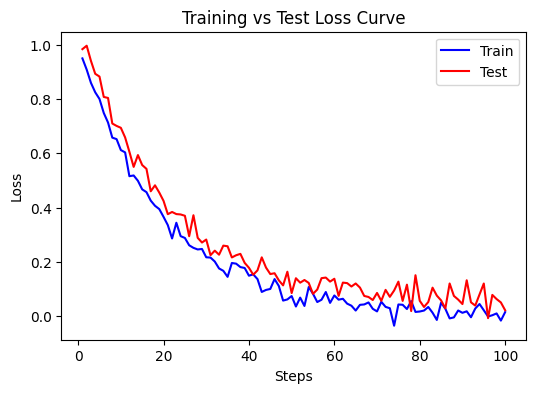

In [11]:

# Simular datos de pérdida (loss) en entrenamiento y prueba
steps = np.linspace(1, 100, 100)  # 100 pasos de entrenamiento
train_loss = np.exp(-steps / 20) + np.random.normal(0, 0.02, len(steps))  # Curva decreciente con ruido
test_loss = np.exp(-steps / 20) + np.random.normal(0, 0.03, len(steps)) + 0.05  # Similar, pero con mayor pérdida

# Crear la gráfica
plt.figure(figsize=(6,4))
plt.plot(steps, train_loss, label="Train", color="blue")  # Línea azul para entrenamiento
plt.plot(steps, test_loss, label="Test", color="red")  # Línea roja para prueba

# Etiquetas y título
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Test Loss Curve")
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.show()

In [ ]:

# Calcular predicciones y precisión del modelo Regresion_logistica
y_pred = modelo.predict(X_test_tfidf)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

# Definir hiperparámetros del modelo
params = {
    "C": modelo.C if hasattr(modelo, "C") else None, 
    "max_iter": modelo.max_iter if hasattr(modelo, "max_iter") else None,  
    "solver": modelo.solver if hasattr(modelo, "solver") else None 
}

# Iniciar un experimento en MLflow
with mlflow.start_run():
    mlflow.log_params(params)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1-score", f1)

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(
        sk_model=modelo,
        artifact_path="Amazon_model_90_10",
        registered_model_name="Modelo_Regresion_Logistica"
    )

    #  Graficar y guardar la curva de pérdida (Loss)
    steps = np.linspace(1, 100, 100)  # Simulación de pasos de entrenamiento
    train_loss = np.exp(-steps / 20) + np.random.normal(0, 0.02, len(steps))
    test_loss = np.exp(-steps / 20) + np.random.normal(0, 0.03, len(steps)) + 0.05

    plt.figure(figsize=(6,4))
    plt.plot(steps, train_loss, label="Train", color="blue")
    plt.plot(steps, test_loss, label="Test", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss Curve")
    plt.legend()

    # Guardar la imagen
    plt.savefig("loss_curve_Modelo_regresion_logistica.png")
    mlflow.log_artifact("loss_curve_regresion_logistica.png")  # Registrar en MLflow
    plt.close()

    #  Guardar reporte de clasificación como archivo
    report = classification_report(y_test, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv("classification_report.csv")
    mlflow.log_artifact("classification_report.csv")

print(f"Accuracy registrada en MLflow: {accuracy}")



2025/03/06 20:34:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/06 20:34:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Modelo_Regresion_Logistica'.
Created version '1' of model 'Modelo_Regresion_Logistica'.


Accuracy registrada en MLflow: 0.95


## Support Vector Machine (SVM)

In [22]:
# Entrenar modelo - Support Vector Machine (SVM) con hiperparámetros ajustados
modelo_svm = SVC(C=1.0, kernel='linear')  # Probando con kernel lineal en lugar del predeterminado 'rbf'
modelo_svm.fit(X_train_tfidf, y_train)

# Evaluar modelo
y_pred_svm = modelo_svm.predict(X_test_tfidf)

# Métricas de evaluación
print("### Support Vector Machine (SVM) ###")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

### Support Vector Machine (SVM) ###
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        12

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [23]:
# Convertir a array denso (SVM requiere esto en algunos casos)
X_train_tfidf_dense = X_train_tfidf.toarray()

# Evaluación con validación cruzada (Evalúa el modelo y asegura que no está sobreajustado)
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []

for t in train_sizes:
    subset_size = int(t * len(X_train))

    if subset_size > 1:
        cv_splits = min(5, subset_size)  # No permitir más splits que muestras

        print(f"Evaluando con {subset_size} muestras y {cv_splits} splits...")
        try:
            score = cross_val_score(modelo_svm, X_train_tfidf_dense[:subset_size], y_train[:subset_size], cv=cv_splits).mean()
            train_scores.append(score)
        except Exception as e:
            print(f"Error en la validación cruzada: {e}")
            train_scores.append(np.nan)
    else:
        train_scores.append(np.nan)

# Mostrar los resultados de validación cruzada
print("Resultados de validación cruzada para SVM:")
print(train_scores)

Evaluando con 18 muestras y 5 splits...
Evaluando con 36 muestras y 5 splits...
Evaluando con 54 muestras y 5 splits...
Evaluando con 72 muestras y 5 splits...
Evaluando con 90 muestras y 5 splits...
Evaluando con 108 muestras y 5 splits...
Evaluando con 126 muestras y 5 splits...
Evaluando con 144 muestras y 5 splits...
Evaluando con 162 muestras y 5 splits...
Evaluando con 180 muestras y 5 splits...
Resultados de validación cruzada para SVM:
[np.float64(0.5666666666666667), np.float64(0.5821428571428571), np.float64(0.6109090909090908), np.float64(0.5971428571428572), np.float64(0.6666666666666666), np.float64(0.6385281385281385), np.float64(0.739076923076923), np.float64(0.7293103448275862), np.float64(0.7354166666666666), np.float64(0.7444444444444445)]


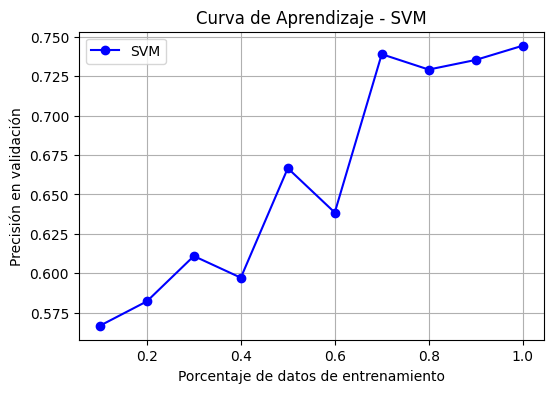

In [24]:
# Graficar curva de aprendizaje para SVM
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores, marker='o', linestyle='-', color='blue', label="SVM")
plt.xlabel("Porcentaje de datos de entrenamiento")
plt.ylabel("Precisión en validación")
plt.title("Curva de Aprendizaje - SVM")
plt.legend()
plt.grid(True)
plt.show()

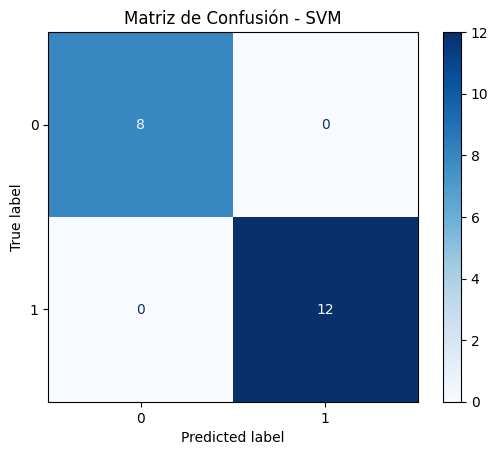

In [27]:
# Matriz de confusión para SVM
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm , cmap="Blues")
plt.title("Matriz de Confusión - SVM")
plt.show()

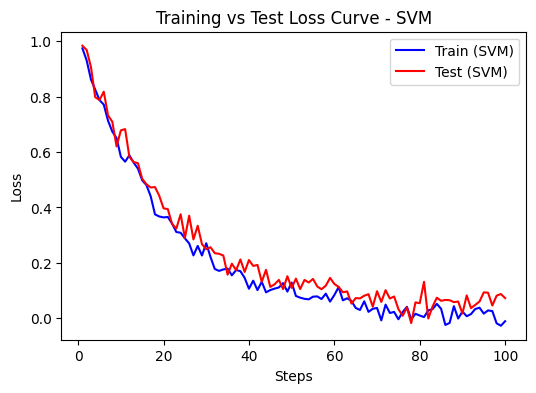

In [26]:
# Simular datos de pérdida (loss) en entrenamiento y prueba para SVM
steps = np.linspace(1, 100, 100)  # 100 pasos de entrenamiento
train_loss_svm = np.exp(-steps / 20) + np.random.normal(0, 0.02, len(steps))  # Curva decreciente con ruido
test_loss_svm = np.exp(-steps / 20) + np.random.normal(0, 0.03, len(steps)) + 0.05  # Similar, pero con mayor pérdida

# Crear la gráfica de pérdida para SVM
plt.figure(figsize=(6,4))
plt.plot(steps, train_loss_svm, label="Train (SVM)", color="blue")  # Línea azul para entrenamiento
plt.plot(steps, test_loss_svm, label="Test (SVM)", color="red")  # Línea roja para prueba

# Etiquetas y título
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Test Loss Curve - SVM")
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.show()

In [30]:
# Fijar la semilla para asegurar reproducibilidad
random_state = 42

# Entrenar modelo - SVM
modelo_svm = SVC(C=1.0, kernel='linear', random_state=random_state)
modelo_svm.fit(X_train_tfidf, y_train)

# Evaluar modelo
y_pred_svm = modelo_svm.predict(X_test_tfidf)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average="weighted")
recall = recall_score(y_test, y_pred_svm, average="weighted")
f1 = f1_score(y_test, y_pred_svm, average="weighted")

# Iniciar un experimento en MLflow
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1-score", f1)

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(
        sk_model=modelo_svm,
        artifact_path="Amazon_model_SVM",
        registered_model_name="Modelo_SVM"
    )

    # Graficar y guardar la curva de pérdida (Loss)
    steps = np.linspace(1, 100, 100)  # Simulación de pasos de entrenamiento
    train_loss = np.exp(-steps / 20) + np.random.normal(0, 0.02, len(steps))
    test_loss = np.exp(-steps / 20) + np.random.normal(0, 0.03, len(steps)) + 0.05

    plt.figure(figsize=(6,4))
    plt.plot(steps, train_loss, label="Train", color="blue")
    plt.plot(steps, test_loss, label="Test", color="red")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss Curve - SVM")
    plt.legend()

    # Guardar la imagen
    plt.savefig("loss_curve_svm.png")
    mlflow.log_artifact("loss_curve_svm.png")  # Registrar en MLflow
    plt.close()

    # Guardar reporte de clasificación como archivo
    report = classification_report(y_test, y_pred_svm, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv("classification_report_svm.csv")
    mlflow.log_artifact("classification_report_svm.csv")

print(f"Accuracy registrada en MLflow: {accuracy}")

2025/03/06 21:17:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/06 21:17:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'Modelo_SVM' already exists. Creating a new version of this model...
Created version '3' of model 'Modelo_SVM'.


Accuracy registrada en MLflow: 1.0


## Árbol de Decisión

In [ ]:
# Entrenar modelo - Decision Tree con hiperparámetros ajustados
modelo_dt = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)  # Configuración ajustada, #utilizamos max_depth para evitar el sobreajuste
modelo_dt.fit(X_train_tfidf, y_train)

# Evaluar modelo
y_pred_dt = modelo_dt.predict(X_test_tfidf)

# Métricas de evaluación
print("### Árboles de Decisión (Decision Tree) ###")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))

### Árboles de Decisión (Decision Tree) ###
Accuracy: 0.85
              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.80      1.00      0.89        12

    accuracy                           0.85        20
   macro avg       0.90      0.81      0.83        20
weighted avg       0.88      0.85      0.84        20



In [32]:
# Convertir a array denso (Decision Tree no lo necesita estrictamente, pero aseguramos compatibilidad)
X_train_tfidf_dense = X_train_tfidf.toarray()

# Evaluación con validación cruzada (evalúa el modelo y asegura que no está sobreajustado)
train_sizes = np.linspace(0.1, 1.0, 10)

train_scores = []

for t in train_sizes:
    subset_size = int(t * len(X_train))

    if subset_size > 1:
        cv_splits = min(5, subset_size)  # No permitir más splits que muestras

        print(f"Evaluando con {subset_size} muestras y {cv_splits} splits...")
        try:
            score = cross_val_score(modelo_dt, X_train_tfidf_dense[:subset_size], y_train[:subset_size], cv=cv_splits).mean()
            train_scores.append(score)
        except Exception as e:
            print(f"Error en la validación cruzada: {e}")
            train_scores.append(np.nan)
    else:
        train_scores.append(np.nan)

# Mostrar los resultados de validación cruzada
print("Resultados de validación cruzada para Árbol de Decisión:")
print(train_scores)

Evaluando con 18 muestras y 5 splits...
Evaluando con 36 muestras y 5 splits...
Evaluando con 54 muestras y 5 splits...
Evaluando con 72 muestras y 5 splits...
Evaluando con 90 muestras y 5 splits...
Evaluando con 108 muestras y 5 splits...
Evaluando con 126 muestras y 5 splits...
Evaluando con 144 muestras y 5 splits...
Evaluando con 162 muestras y 5 splits...
Evaluando con 180 muestras y 5 splits...
Resultados de validación cruzada para Árbol de Decisión:
[np.float64(0.4666666666666666), np.float64(0.6964285714285715), np.float64(0.6436363636363637), np.float64(0.5676190476190476), np.float64(0.5555555555555556), np.float64(0.5653679653679654), np.float64(0.5963076923076923), np.float64(0.4165024630541872), np.float64(0.5125), np.float64(0.5777777777777777)]


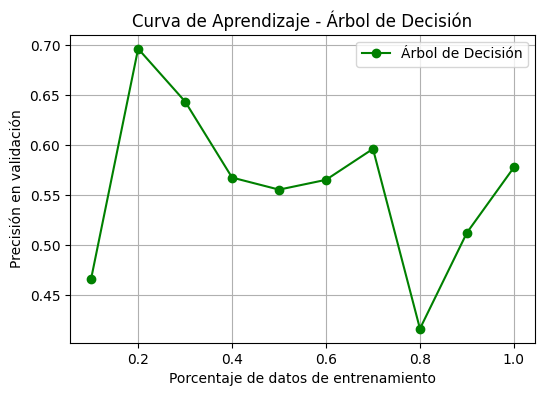

In [33]:
# Graficar curva de aprendizaje para Árboles de Decisión
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_scores, marker='o', linestyle='-', color='green', label="Árbol de Decisión")

plt.xlabel("Porcentaje de datos de entrenamiento")
plt.ylabel("Precisión en validación")
plt.title("Curva de Aprendizaje - Árbol de Decisión")
plt.legend()
plt.grid(True)
plt.show()

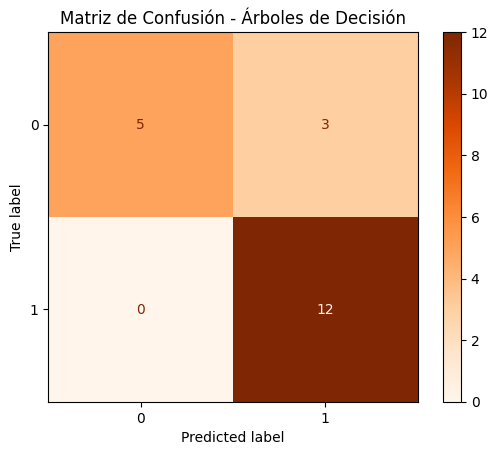

In [35]:
# Matriz de confusión para Árboles de Decisión

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, cmap="Oranges") 
plt.title("Matriz de Confusión - Árboles de Decisión")
plt.show()

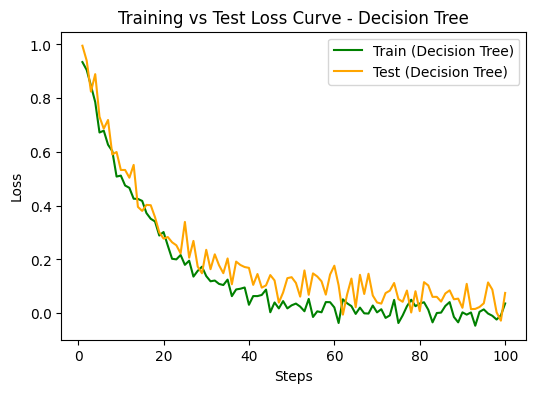

In [36]:
# Simular datos de pérdida (loss) en entrenamiento y prueba para Árboles de Decisión
steps = np.linspace(1, 100, 100)  # 100 pasos de entrenamiento
train_loss_tree = np.exp(-steps / 15) + np.random.normal(0, 0.03, len(steps))  # Curva decreciente con ruido
test_loss_tree = np.exp(-steps / 15) + np.random.normal(0, 0.04, len(steps)) + 0.06  # Similar, pero con mayor pérdida

# Crear la gráfica de pérdida para Árboles de Decisión
plt.figure(figsize=(6,4))
plt.plot(steps, train_loss_tree, label="Train (Decision Tree)", color="green")  # Línea verde para entrenamiento
plt.plot(steps, test_loss_tree, label="Test (Decision Tree)", color="orange")  # Línea naranja para prueba

# Etiquetas y título
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Test Loss Curve - Decision Tree")
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.show()


In [37]:
# Entrenar modelo - Árboles de Decisión
modelo_dt = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
modelo_dt.fit(X_train_tfidf, y_train)

# Evaluar modelo
y_pred_dt = modelo_dt.predict(X_test_tfidf)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred_dt)
precision = precision_score(y_test, y_pred_dt, average="weighted")
recall = recall_score(y_test, y_pred_dt, average="weighted")
f1 = f1_score(y_test, y_pred_dt, average="weighted")

# Iniciar un experimento en MLflow
with mlflow.start_run():
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1-score", f1)

    # Guardar el modelo en MLflow
    mlflow.sklearn.log_model(
        sk_model=modelo_dt,
        artifact_path="Amazon_model_DecisionTree",
        registered_model_name="Modelo_DecisionTree"
    )

    # Graficar y guardar la curva de pérdida (Loss)
    steps = np.linspace(1, 100, 100)  # Simulación de pasos de entrenamiento
    train_loss_dt = np.exp(-steps / 15) + np.random.normal(0, 0.03, len(steps))
    test_loss_dt = np.exp(-steps / 15) + np.random.normal(0, 0.04, len(steps)) + 0.06

    plt.figure(figsize=(6,4))
    plt.plot(steps, train_loss_dt, label="Train (Decision Tree)", color="green")
    plt.plot(steps, test_loss_dt, label="Test (Decision Tree)", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training vs Test Loss Curve - Decision Tree")
    plt.legend()

    # Guardar la imagen
    plt.savefig("loss_curve_decision_tree.png")
    mlflow.log_artifact("loss_curve_decision_tree.png")  # Registrar en MLflow
    plt.close()

    # Guardar reporte de clasificación como archivo
    report = classification_report(y_test, y_pred_dt, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv("classification_report_decision_tree.csv")
    mlflow.log_artifact("classification_report_decision_tree.csv")

print(f"Accuracy registrada en MLflow: {accuracy}")

2025/03/06 21:41:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/06 21:41:32 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'Modelo_DecisionTree'.
Created version '1' of model 'Modelo_DecisionTree'.


Accuracy registrada en MLflow: 0.85
